# Executive Summary

in certain industries, long-term reservations and then cancellations
<br>

Data source is from: 
<br>

Helping to create more accurate predictions. 


# Technical Summary



__Data separation__: 
<br>

We want to keep everything consistent, and bring under the same framework
<br>

main issue: logreg needs first dummies dropped, decision tree does need all the dummies
this is the nameing that we are going to use, `_logreg` is a data where the first dummies are dropped, `_dtree` where it is not. different models can be used, but these two are the main underlying ones, hence our naming decision

- as a first step, we get an even sample of df, where prevalence = 0.5
- `y` is the `IsCanceled` column of the data, `X_orig` is everything else
- there are two differnt types of datasets that we need. for logreg, no full dummy, scaled, for dtree, full dummy, not scaled, we are calling these `_logreg` and `_dtree`
- under both routes, we separate 3k observations for final testing (not to be touched until the end of the project with the final model), and 3k observations for validating each of the models
- in summary, we will have six data - target pairs: `_train_logreg`, `_valid_logreg`, `_test_logreg`, `_train_dtree`, `_valid_dtree`, `_test_dtree`.  


__Model selection__: 
<br>

- for each model type, we are first using a `GridsearchCV` method with cross-validation being the same `cv` object, `roc_auc` being the score, parameters are model-specific, on the corresponding `_train` data
- once we have a model, we consider the threshold we need to set - see Section 3.3 for more details
- the chosen model of the specific type will be then fit on the whole X_train population, with the calculated hyperparameters
- we check how well the model performs on the `_valid` datasets
- we are calculating all the usual scores (accuracy, f1, auc, etc), but the score we will make our decision based on is the zweig_campbell score, which equals True Positive Rate - m * False Positive Rate
- this process is repeated for the different model types, we pick the best one at the end, and compare how it performs against the test data

# Setting up the Infrastructure

Importing libraries, getting data in, creating databases, considering threshold

In [223]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image  

from sklearn.metrics import SCORERS, precision_score, recall_score, \
    accuracy_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, \
    cross_validate, cross_val_predict, KFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [5]:
# read in dataset
df = pd.read_csv('H1_clean.csv')

# get an even sample, get rows where cancel = 1, randomly select the same amount of cancel = 0, concat
df_canc = df[df['IsCanceled'] == 1]
rownum = len(df_canc)
df_noncanc = df[df['IsCanceled'] == 0]
df_noncanc = df_noncanc.sample(n = rownum)
df = pd.concat([df_canc, df_noncanc])

# set random seed, to be used for the whole project for reproducability
random_seed = 12345
np.random.seed(random_seed)

# set cross-validation, to be kept fixed
cv = KFold(n_splits = 5, shuffle = True, random_state = random_seed)

X_orig = df.drop('IsCanceled', axis = 1)
y = df['IsCanceled']

## Data - First Dummies Dropped, Scaled

We need to keep logreg data separate from the others,  significant portion is the dummies and we have to drop the first to avoid perfect linear dependence between columns. 
<br>

Also, this type is scaled. 

In [150]:
X = pd.get_dummies(X_orig, drop_first = True)

# splitting first for train - test
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = \
    train_test_split(
        X, y, test_size=3000, random_state = random_seed
    )

# then, splitting for train - validation
X_train_logreg, X_valid_logreg, y_train_logreg, y_valid_logreg = \
    train_test_split(
        X_train_logreg, y_train_logreg, test_size = 3000, random_state = random_seed
    )

# finally, scaling
scaler_logreg = StandardScaler()
X_train_logreg = scaler_logreg.fit_transform(X_train_logreg)

X_valid_logreg = scaler_logreg.transform(X_valid_logreg)
X_test_logreg = scaler_logreg.transform(X_test_logreg)

## Data - First Dummies Not Dropped, Not Scaled

Primarily for decision tree type of models. 

In [122]:
X = pd.get_dummies(X_orig, drop_first = True)

# splitting first for train - test
X_train_dtree, X_test_dtree, y_train_dtree, y_test_dtree = \
    train_test_split(
        X, y, test_size=3000, random_state = random_seed
    )

# then, splitting for train - validation
X_train_dtree, X_valid_dtree, y_train_dtree, y_valid_dtree = \
    train_test_split(
        X_train_dtree, y_train_dtree, test_size = 3000, random_state = random_seed
    )

These should match, because we are using the same random seed. Wouldn't hurt the model's performance to keep these random, but just to check that we are indeed on the same split: 

In [123]:
(y_train_dtree != y_train_logreg).sum()

0

## Threshold Selection Parameter

Picking a threshold. 
<br>

m = (1 - prevalence) / prevalence * (CFP - CTN) / (CFN - CTP)
<br>

we have a balanced set, so prevalence is around 0.5 -> first item is around 1
<br> 

Cost item: two aspects: overbooking, financial analysis accuracy. In overbooking, the cost of assuming they will cancel when in reality they show up is higher than assuming they will be there and they won't, because presumably we need to pay compensation. It's questionable how often this happens with hotels though. In financial analysis, it could be more detremential to assume higher prfoits than to use a conservative one. So it is worse to assume they will come when in reality they won't, which means the false negative is worse. 
They are in opposite direction. So the prediction function can be changed depending on the use of the model. 
<br> 

For now, we use the model for the financial forecast, which means we need to apply a "conservativism score". We want to minimize FN's - if we say someone does not cancel, we better be sure. This is ultimately a judgement call, we will use 1 / 1.5 now. The cost of assuming that someone will come when in fact they will cancel is assumed to be 50% more than the opposite. This means the logregression would focus on getting the FPs out, m = 1/1.5

In [124]:
prevalence = sum(y_train_logreg) / len(y_train_logreg)
cost_ratio = 1/1.2
m = (1 - prevalence) / prevalence * cost_ratio
m

0.8428607723577236

# Logistic Regression

In this section, longreg on Searching for best estimator with grid search. 

In [125]:
logreg = LogisticRegression(solver='liblinear')

## GSCV Iteration 1

In [126]:
param_grid = {
    'C':[1, 10, 10**2, 10**3, 10**4], 
    'max_iter':[100, 1000],
    'penalty': ['l1', 'l2']
}

gs_log = GridSearchCV(logreg, param_grid, scoring = 'roc_auc', cv = cv)

gs_log.fit(X_train_logreg, y_train_logreg)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [127]:
gs_log.best_score_

0.9123475891064039

In [128]:
gs_log.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Best logreg is with `C` = 1000, `max_iter` = 100, `penalty` = `l2` from the first grid. Picking new iteration variables around these. 

## GSCV Iteration 2

In [129]:
param_grid_2 = {
    'C': [500, 1000, 5000], 
    'max_iter': [50, 100, 500],
    'penalty': ['l1', 'l2']
}

gs_log_2 = GridSearchCV(logreg, param_grid_2, scoring = 'roc_auc', cv = cv)

gs_log_2.fit(X_train_logreg, y_train_logreg)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [500, 1000, 5000], 'max_iter': [50, 100, 500],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [130]:
gs_log_2.best_score_

0.9123479076917864

In [131]:
gs_log_2.best_estimator_

LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Interesting how max iteration goes down. There is no significant change in the AUC, and the lower the max_iter, the simpler the model is. However, with lower `max_iter`, we risk the model not to converge, keeping it at 50. 
<br>

No significant improvement, we are keeping it here. 

In [132]:
chosen_C = gs_log_2.best_estimator_.C
chosen_max_iter = gs_log_2.best_estimator_.max_iter
chosen_penalty = gs_log_2.best_estimator_.penalty

## Fitting the Chosen Model & Threshold Selection

In [134]:
logreg_chosen = LogisticRegression(
    C = chosen_C, max_iter = chosen_max_iter, penalty = chosen_penalty, solver = 'liblinear'
    )

logreg_chosen.fit(X_train_logreg, y_train_logreg)

y_train_prediction_probabilities_logreg = logreg_chosen.predict_proba(X_train_logreg)

fpr_train_logreg, tpr_train_logreg, thresholds_train_logreg = \
    roc_curve(y_train_logreg, y_train_prediction_probabilities_logreg[:,1])

auc(fpr_train_logreg, tpr_train_logreg)

0.9144915498643965

Performs a bit better on the whole data set, 0.912 above was from a cross-validated score. 

In [135]:
zweig_campbell_scores_train_logreg = \
    tpr_train_logreg - m * fpr_train_logreg

chosen_threshold_logreg = \
    thresholds_train_logreg[np.argmax(zweig_campbell_scores_train_logreg)]

chosen_threshold_logreg

0.43484214452380127

If the probability of canceling is above that, we say it is going to be cancelled. (So there is a relatively higher chance of classifying something as being cancelled.)

Calculating train predictions in case we ever want to do a stacking model. 

In [136]:
y_train_prediction_logreg = (y_train_prediction_probabilities_logreg[:,1] > chosen_threshold_logreg) * 1

## Validation and Visualisation

We are checking the overfitting, calculating final test scores. 

In [151]:
y_valid_prediction_probabilities_logreg = \
    logreg_chosen.predict_proba(X_valid_logreg)

fpr_valid_logreg, tpr_valid_logreg, thresholds_valid_logreg = \
    roc_curve(y_valid_logreg, y_valid_prediction_probabilities_logreg[:,1])

Visualisation

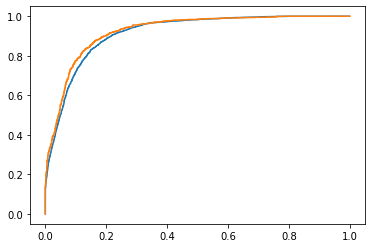

In [152]:
plt.plot(fpr_train_logreg, tpr_train_logreg)
plt.plot(fpr_valid_logreg, tpr_valid_logreg)

Prediction with chosen threshold

In [153]:
y_valid_prediction_logreg = \
    (y_valid_prediction_probabilities_logreg[:,1] > chosen_threshold_logreg) * 1

Scores

In [175]:
# TODO PUT IN SEPARATE .PY FILE

def calculate_scores(y_train_true, y_train_pred, y_valid_true, y_valid_pred, m, verbose = False):
    """
    calculates scores, updates dictionary with relevant scores
    if verbose is true, also prints out results
    returns a dictionary
    """
    
    scoring_dictionary = {}
    
    scoring_dictionary['train_accuracy'] = accuracy_score(y_train_true, y_train_pred)
    scoring_dictionary['validation_accuracy'] = accuracy_score(y_valid_true, y_valid_pred)
    scoring_dictionary['train_f1'] = f1_score(y_train_true, y_train_pred)
    scoring_dictionary['validation_f1'] = f1_score(y_valid_true, y_valid_pred)
    scoring_dictionary['train_auc'] = roc_auc_score(y_train_true, y_train_pred)
    scoring_dictionary['validation_auc'] = roc_auc_score(y_valid_true, y_valid_pred)
    scoring_dictionary['train_zweigcampbell'] = \
        calculate_zweig_campbell_score(y_train_true, y_train_pred, m)
    scoring_dictionary['validation_zweigcampbell'] = \
        calculate_zweig_campbell_score(y_valid_true, y_valid_pred, m)
    
    if verbose:
        print("Train accuracy : " + str(scoring_dictionary['train_accuracy']))
        print("Validation accuracy : " + str(scoring_dictionary['validation_accuracy']))
        print("Train F1 : " + str(scoring_dictionary['train_f1']))
        print("Validation F1 : " + str(scoring_dictionary['validation_f1']))
        print("Train AUC : " + str(scoring_dictionary['train_auc']))
        print("Validation AUC : " + str(scoring_dictionary['validation_auc']))
        print("Train Zweig-Campbell : " + str(scoring_dictionary['train_zweigcampbell']))
        print("Validation Zweig-Campbell : " + str(scoring_dictionary['validation_zweigcampbell']))
        
    return scoring_dictionary
    
    
def calculate_zweig_campbell_score(y_true, y_pred, m):
    """
    calculates tpr - m * fpr
    """
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)

    return tpr - fpr * m
    

In [176]:
logreg_scores = calculate_scores(
    y_train_logreg, y_train_prediction_logreg, 
    y_valid_logreg, y_valid_prediction_logreg, 
    m, verbose = True
    )

Train accuracy : 0.8421119110774283
Validation accuracy : 0.8516666666666667
Train F1 : 0.8507819028291752
Validation F1 : 0.8615001556178026
Train AUC : 0.8424693839181233
Validation AUC : 0.8508712660028449
Train Zweig-Campbell : 0.7195757113821138
Validation Zweig-Campbell : 0.7345506545337057


# Decision Tree

In this section, longreg on Searching for best estimator with grid search. 

`class_weight`: we use this to encounter for the cost imbalance, as decided above, FN has a higher cost for us, than FP. class 0 (IsCanceled = 0) has a higher cost in our case, 

In [156]:
dtc = DecisionTreeClassifier(class_weight = {0: 1, 1: cost_ratio})

## GSCV Iteration 1

In [157]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50], 
    'min_samples_leaf':[5, 10, 20, 50],
    'max_features': [5, 10, 20, 50]
}

gs_dtree = GridSearchCV(dtc, param_grid, scoring = 'roc_auc', cv = cv)

gs_dtree.fit(X_train_dtree, y_train_dtree)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight={0: 1,
                                                            1: 0.8333333333333334},
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_stat

In [158]:
gs_dtree.best_score_

0.9345732523038495

In [159]:
gs_dtree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 1, 1: 0.8333333333333334},
                       criterion='entropy', max_depth=20, max_features=50,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

The limiting factor is probably the `min_sample_leaf`. 

## GSCV Iteration 2

In [160]:
param_grid_2 = {
    'criterion': ['entropy'],
    'max_depth':[15, 20, 30], 
    'min_samples_leaf':[15, 20, 30],
    'max_features': [30, 50, 65]
}

gs_dtree_2 = GridSearchCV(dtc, param_grid_2, scoring = 'roc_auc', cv = cv)

gs_dtree_2.fit(X_train_dtree, y_train_dtree)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight={0: 1,
                                                            1: 0.8333333333333334},
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_stat

In [161]:
gs_dtree_2.best_score_

0.9366248308500268

In [162]:
gs_dtree_2.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 1, 1: 0.8333333333333334},
                       criterion='entropy', max_depth=15, max_features=65,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

OK, not much increase, keeping the parameters as they are, limiting max_features.

## Fitting the Chosen Model & Threshold Selection

In [99]:
chosen_criterion = gs_dtree_2.best_estimator_.criterion
chosen_max_depth = gs_dtree_2.best_estimator_.max_depth
chosen_min_samples_leaf = gs_dtree_2.best_estimator_.min_samples_leaf

In [165]:
dtree_chosen = DecisionTreeClassifier(
    criterion = chosen_criterion, max_depth = chosen_max_depth, 
    min_samples_leaf = chosen_min_samples_leaf
    )

dtree_chosen.fit(X_train_dtree, y_train_dtree)

y_train_prediction_probabilities_dtree = dtree_chosen.predict_proba(X_train_dtree)

fpr_train_dtree, tpr_train_dtree, thresholds_train_dtree = \
    roc_curve(y_train_dtree, y_train_prediction_probabilities_dtree[:,1])

auc(fpr_train_dtree, tpr_train_dtree)

0.9676925125034972

In [168]:
zweig_campbell_scores_train_dtree = \
    tpr_train_dtree - m * fpr_train_dtree

chosen_threshold_dtree = \
    thresholds_train_dtree[np.argmax(zweig_campbell_scores_train_dtree)]

chosen_threshold_dtree

0.46153846153846156

In [169]:
y_train_prediction_dtree = (y_train_prediction_probabilities_dtree[:,1] > chosen_threshold_dtree) * 1

## Validation and Visualisation

In [170]:
y_valid_prediction_probabilities_dtree = \
    dtree_chosen.predict_proba(X_valid_dtree)

fpr_valid_dtree, tpr_valid_dtree, thresholds_valid_dtree = \
    roc_curve(y_valid_dtree, y_valid_prediction_probabilities_dtree[:,1])

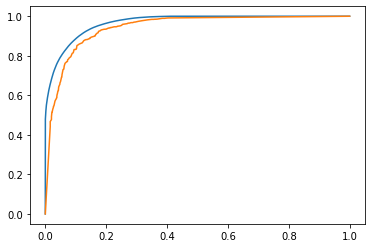

In [171]:
plt.plot(fpr_train_dtree, tpr_train_dtree)
plt.plot(fpr_valid_dtree, tpr_valid_dtree)

In [173]:
y_valid_prediction_dtree = \
    (y_valid_prediction_probabilities_dtree[:,1] > chosen_threshold_dtree) * 1

In [177]:
dtree_scores = calculate_scores(
    y_train_dtree, y_train_prediction_dtree, 
    y_valid_dtree, y_valid_prediction_dtree, 
    m, verbose = True
    )

Train accuracy : 0.8949728432487053
Validation accuracy : 0.8713333333333333
Train F1 : 0.8974659350144892
Validation F1 : 0.8754034861200775
Train AUC : 0.8951399674367881
Validation AUC : 0.8710526315789473
Train Zweig-Campbell : 0.811377879403794
Validation Zweig-Campbell : 0.7656761473042362


# Random Forest - GridSearchCV

In [180]:
rfc = RandomForestClassifier(class_weight = {0: 1, 1: cost_ratio}, oob_score=True)

## GSCV Iteration 1

In [189]:
# runs for 10 minutes

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators':[50,100], 
    'max_depth': [10, 20, 50],
    'min_samples_leaf':[10, 20, 50],
    'max_features': [10, 20, 50]
}

gs_rfc = GridSearchCV(rfc, param_grid, scoring = 'roc_auc', cv = cv)

gs_rfc.fit(X_train_dtree, y_train_dtree)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 1,
                                                            1: 0.8333333333333334},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samp...
                                              n_estimators=100, n_jobs=None,
                                              oob_s

In [192]:
gs_rfc.best_score_

0.9546300727874307

In [193]:
gs_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 0.8333333333333334},
                       criterion='entropy', max_depth=50, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

Runs for a very long time, and the chosen parameters are either in the middle, or we do not want to relax them any furthert (like max_depth and min_samples_leaf). 

## Fitting the Chosen Model & Threshold Selection

In [198]:
chosen_criterion = gs_rfc.best_estimator_.criterion
chosen_n_estimators = gs_rfc.best_estimator_.n_estimators
chosen_max_depth = gs_rfc.best_estimator_.max_depth
chosen_min_samples_leaf = gs_rfc.best_estimator_.min_samples_leaf
chosen_max_features = gs_rfc.best_estimator_.max_features

In [201]:
rcfgs_chosen = RandomForestClassifier(
    criterion = chosen_criterion, 
    n_estimators = chosen_n_estimators,
    max_depth = chosen_max_depth, 
    min_samples_leaf = chosen_min_samples_leaf,
    max_features = chosen_max_features
    )

rcfgs_chosen.fit(X_train_dtree, y_train_dtree)

y_train_prediction_probabilities_rcfgs = rcfgs_chosen.predict_proba(X_train_dtree)

fpr_train_rcfgs, tpr_train_rcfgs, thresholds_train_rcfgs = \
    roc_curve(y_train_dtree, y_train_prediction_probabilities_rcfgs[:,1])

auc(fpr_train_rcfgs, tpr_train_rcfgs)

0.9780840901676255

In [202]:
zweig_campbell_scores_train_rcfgs = \
    tpr_train_rcfgs - m * fpr_train_rcfgs

chosen_threshold_rcfgs = \
    thresholds_train_rcfgs[np.argmax(zweig_campbell_scores_train_rcfgs)]

chosen_threshold_rcfgs

0.44382070493409226

In [203]:
y_train_prediction_rcfgs = (y_train_prediction_probabilities_rcfgs[:,1] > chosen_threshold_rcfgs) * 1

## Validation and Visualisation

In [206]:
y_valid_prediction_probabilities_rcfgs = \
    rcfgs_chosen.predict_proba(X_valid_dtree)

fpr_valid_rcfgs, tpr_valid_rcfgs, thresholds_valid_rcfgs = \
    roc_curve(y_valid_dtree, y_valid_prediction_probabilities_rcfgs[:,1])

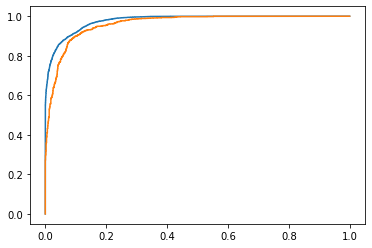

In [207]:
plt.plot(fpr_train_rcfgs, tpr_train_rcfgs)
plt.plot(fpr_valid_rcfgs, tpr_valid_rcfgs)

In [208]:
y_valid_prediction_rcfgs = \
    (y_valid_prediction_probabilities_rcfgs[:,1] > chosen_threshold_rcfgs) * 1

In [210]:
rcfgs_scores = calculate_scores(
    y_train_dtree, y_train_prediction_rcfgs, 
    y_valid_dtree, y_valid_prediction_rcfgs, 
    m, verbose = True
    )

Train accuracy : 0.9095617026651509
Validation accuracy : 0.8963333333333333
Train F1 : 0.9120285047303108
Validation F1 : 0.9008606949314633
Train AUC : 0.9097504782626009
Validation AUC : 0.8958837126600284
Train Zweig-Campbell : 0.8389015921409214
Validation Zweig-Campbell : 0.813427156697776


# Random Forest - No Hyperparameter Restrictions

Testing if random forest can avoid overfitting via OOB score, which should work similarly to k-fold. 

In [197]:
rfc_chosen = RandomForestClassifier(class_weight = {0: 1, 1: cost_ratio}, oob_score=True)

## Model Fitting & Threshold Selection

In [212]:
rfc_chosen.fit(X_train_dtree, y_train_dtree)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 0.8333333333333334},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [213]:
y_train_prediction_probabilities_rfc = rfc.predict_proba(X_train_dtree)

fpr_train_rfc, tpr_train_rfc, thresholds_train_rfc = \
    roc_curve(y_train_dtree, y_train_prediction_probabilities_rfc[:,1])

auc(fpr_train_rfc, tpr_train_rfc)

0.9999260253352816

In [214]:
zweig_campbell_scores_train_rfc = \
    tpr_train_rfc - m * fpr_train_rfc

chosen_threshold_rfc = \
    thresholds_train_rfc[np.argmax(zweig_campbell_scores_train_rfc)]

chosen_threshold_rfc

0.43205292327734773

In [215]:
y_train_prediction_rfc = (y_train_prediction_probabilities_rfc[:,1] > chosen_threshold_rfc) * 1

## Validation and Visualisation

In [217]:
y_valid_prediction_probabilities_rfc = \
    rfc_chosen.predict_proba(X_valid_dtree)

fpr_valid_rfc, tpr_valid_rfc, thresholds_valid_rfc = \
    roc_curve(y_valid_dtree, y_valid_prediction_probabilities_rfc[:,1])

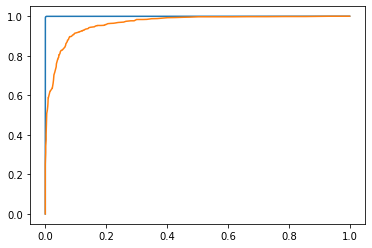

In [218]:
plt.plot(fpr_train_rfc, tpr_train_rfc)
plt.plot(fpr_valid_rfc, tpr_valid_rfc)

In [219]:
y_valid_prediction_rfc = \
    (y_valid_prediction_probabilities_rfc[:,1] > chosen_threshold_rfc) * 1

In [220]:
rfc_scores = calculate_scores(
    y_train_dtree, y_train_prediction_rfc, 
    y_valid_dtree, y_valid_prediction_rfc, 
    m, verbose = True
    )

Train accuracy : 0.9980421876973601
Validation accuracy : 0.9016666666666666
Train F1 : 0.9980333692824971
Validation F1 : 0.9059611093401339
Train AUC : 0.9980489451418629
Validation AUC : 0.9012179943100996
Train Zweig-Campbell : 0.9965912940379404
Validation Zweig-Campbell : 0.8232463187674195


Excluding this for overfitting. 

# Gradient Boosting with XGBoost - GridSearchCV

# Gradient Boosting with XGBoost - No Hyperparameter Tuning

In [224]:
xgbc = XGBClassifier()

# Technical Appendix

Extra models that did not make the cut due to different considerations. 

## K-Nearest Neighbors

In [1]:
# lets try one first

In [10]:
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

In [11]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
knn = KNeighborsClassifier(metric = 'minkowski')

parameters_knn = {'n_neighbors': [3, 5, 9], 'p': [1,2,3]}

gscv_knn = GridSearchCV(knn, param_grid = parameters_knn, cv = cv, scoring = 'accuracy')

In [17]:
# runs for approx. 10 minutes
gscv_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 9], 'p': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [18]:
gscv_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Interestingly, the lowest possible neighbor worked (want to keep it an odd number, n = 1 would be very overfit).
Running with these parameters on the scoring split. 

In [21]:
gscv_knn.best_score_

0.8346602928647384

In [26]:
knn = KNeighborsClassifier(metric = 'minkowski', n_neighbors = 3, p = 2)
knn.fit(X_scoring_train, y_scoring_train)
y_scoring_test_predict_knn = knn.predict(X_scoring_test)

In [27]:
confusion_matrix(y_scoring_test, y_scoring_test_predict_knn)

array([[1428,  336],
       [ 247, 1483]])

In [28]:
accuracy_score(y_scoring_test, y_scoring_test_predict_knn)

0.8331425300515168